In [164]:
# House Price Problem
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy import stats
import warnings

%matplotlib notebook
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'png'

In [165]:
# 데이터 가져오기
df_train = pd.read_csv('./data/train.csv')

In [166]:
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [167]:
df_train.shape

(1460, 81)

## 1. 결과값인 'SalePrice' 분석!

In [168]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

- 데이터 분포도 좋음.
- min값도 0보다 많이 크고, 평균값도 적당. 모든 모델을 적용하는 면에서 좋은 분포도를 가짐.

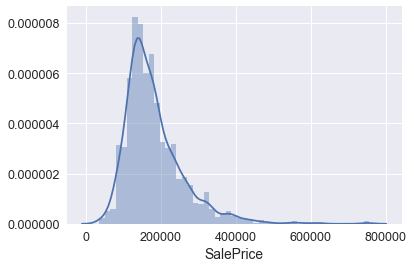

In [169]:
# 히스토그램으로 분포도 포현
sns.distplot(df_train['SalePrice']);

- 정규분포 모양을 띈다.
- 양수적 왜도(비대칭도).
- 'SalaPrice' 는 정규분포가 아님 > regression transform이 필요 > Log Regression을 고려할 수 있음.

In [170]:
# 왜도(skewness) 와 첨도(kurtosis)
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


## 2. 'SalePrice'에 영향을 주는 설명변수들 분석.

### 1) 숫자형 변수(Numerical Data)

In [171]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 20

In [172]:
quantitative = [f for f in df_train.columns if df_train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in df_train.columns if df_train.dtypes[f] == 'object'] 

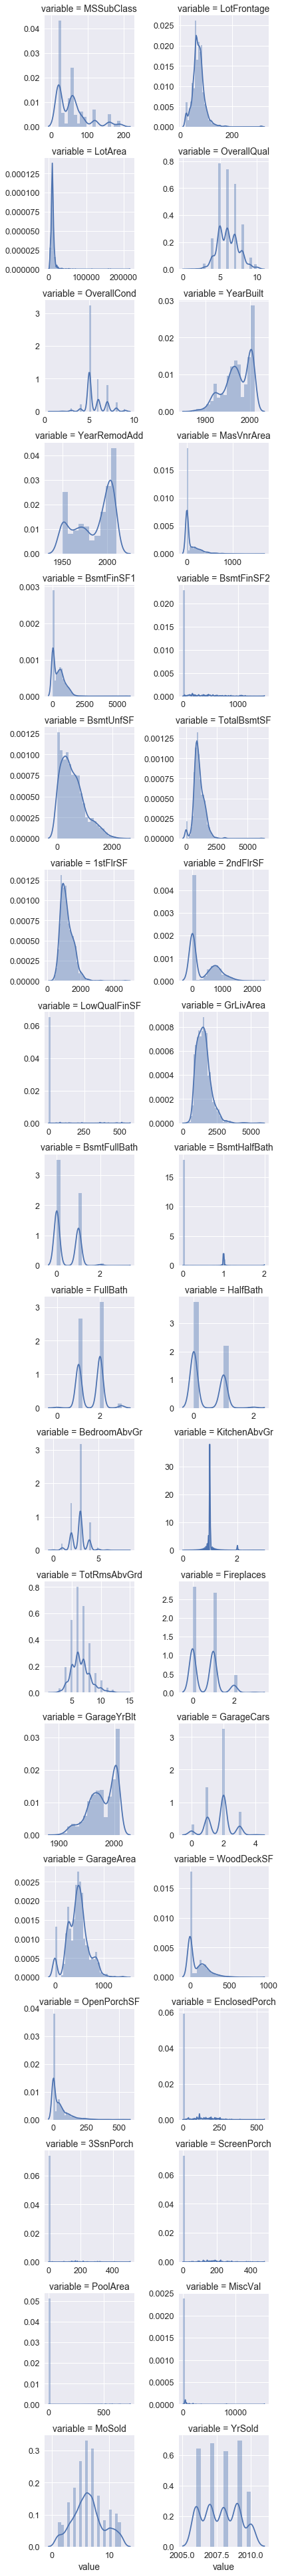

In [173]:
f = pd.melt(df_train, value_vars=quantitative)
g = sns.FacetGrid(f, col='variable', col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

<br>
- 로그변환을 고려해볼 수 있는 설명변수
: TotalBsmtSF, KitchenAbvGr, LotFrontage, LotArea, GrLivArea, BsmtUnfSF 등    
</br>


### 2) 범주형 변수(Categorical Data)

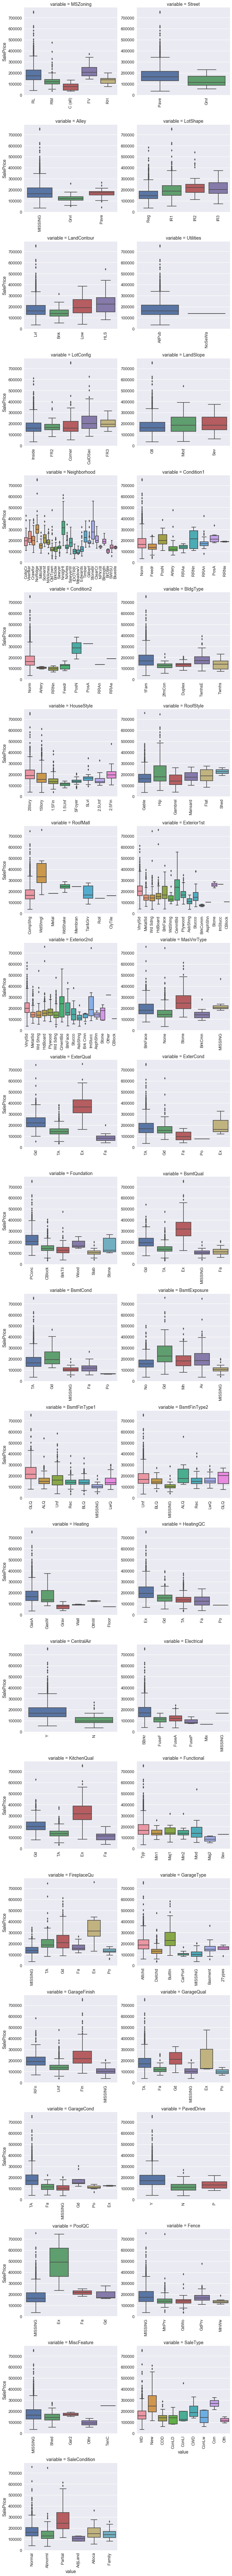

In [174]:
for c in qualitative:
    df_train[c] = df_train[c].astype('category')
    if df_train[c].isnull().any():
        df_train[c] = df_train[c].cat.add_categories(['MISSING'])
        df_train[c] = df_train[c].fillna('MISSING')

def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
f = pd.melt(df_train, id_vars=['SalePrice'], value_vars=qualitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "SalePrice")

- Neighborhood가 SalesPrice에 가장 큰 영향을 미친다 > 다양한 범주에서 가격변화가 크다. 

### 3) 상관관계(Correlations)

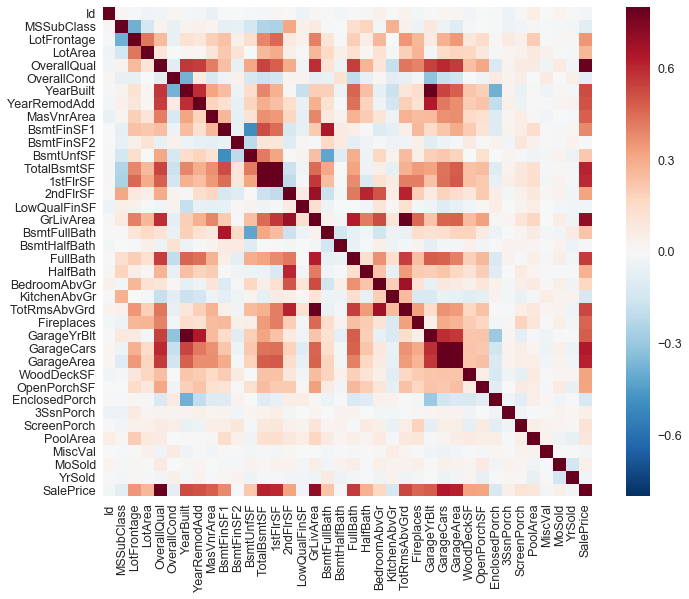

In [175]:
## The plasma soup : Correlation matrix (heatmap style)
#correlation matrix
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

- TotalBsmtSF 와 1stFlrSF : 제일 상관관계가 깊다
- TotalBsmtSF 와 GarageX : 2번째로 상관관계가 깊다.

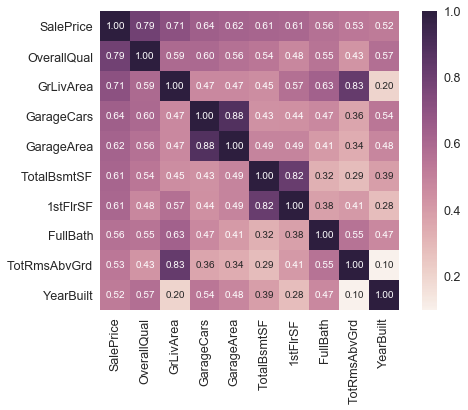

In [176]:
## 'SalePrice' correlation matrix (zoomed heatmap style)
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

- SalesPrice 가장 관련있는 변수 : OverallQual, GrLivArea 
- GarageCars와 GarageArea : 같은 값(twin) >> 관련이 있음.(어떻게 합칠것인지..변수를 논의)

## 3. Linear Regression

- 일단 설명변수, 종속변수(SalesPrice) 들의 분포를 무시하고 기본적인 linear regression 결과를 보았음

In [177]:
# 데이터 가져오기
train_path = "./data/train.csv"
test_path = "./data/test.csv"
output_path = "./submit/1_linear_regression(summary).csv"

In [178]:
## train preprocessing
raw_train_data = pd.read_csv(train_path)
raw_test_data = pd.read_csv(test_path)

In [179]:
raw_train_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [180]:
# raw_test_data.rename(columns={"Id":"Seq"},inplace=True)
raw_test_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
5,1466,60,RL,75.0,10000,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal
6,1467,20,RL,NaN,7980,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,GdPrv,Shed,500,3,2010,WD,Normal
7,1468,60,RL,63.0,8402,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal
8,1469,20,RL,85.0,10176,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2010,WD,Normal
9,1470,20,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,4,2010,WD,Normal


In [181]:
tmp_train_x = raw_train_data.drop('SalePrice',axis=1)
train_y = raw_train_data['SalePrice']
# train 데이터와 test 데이터를 합침.
all_data = pd.concat([tmp_train_x, raw_test_data])

In [182]:
categorical = []
numerical = []
for feature in all_data.columns:
    if all_data[feature].dtype == 'object':
        # 범주형 변수
        categorical.append(feature)
    else:
        # 숫자형 변수
        numerical.append(feature)

nu_df = all_data[numerical]
nu_df = nu_df.fillna(0) # 결측값 0처리
ca_df = pd.DataFrame()

for element in categorical:
    ca_df = pd.concat([ca_df,pd.get_dummies(all_data[element])], axis=1)
# len(categorical)

In [183]:
new_x = pd.concat([nu_df, ca_df], axis=1) # 결측값 처리한 데이터를 나눔.
train_x = new_x.iloc[:1460,:] # 다시 train
test_x = new_x.iloc[1460:,:] # 나머지 test

In [184]:
# linear regression 모델링 수행.
lr = LinearRegression().fit(train_x, train_y)
pred = lr.predict(test_x)

In [185]:
#seq = raw_train_data['Seq']+1461
# result = pd.DataFrame({"Id": [seq], "SalesPrice":[pred]})
np.savetxt(output_path, pred) # 결과값 제출.

![](./image/Baseline.JPG)

[목표: 여기서부터 점점 줄여 나가는 방향으로 설정]
- 결측값만 처리하고 Linear Regression 돌려서 결과값 : 0.19489 


## 4. Lasso & Ridge Regression 
- 참조 : https://www.kaggle.com/apapiu/regularized-linear-models

In [186]:
#데이터 읽어오기
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [187]:
#데이터 머징
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

데이터 전처리
- 정규화, 더미변수 생성, missing value 처리

In [188]:
#타겟 변수 로그 변환
train["SalePrice"] = np.log1p(train["SalePrice"])

#왜도인 numeric features 로그 변환
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [189]:
#더미 변수 생성
all_data = pd.get_dummies(all_data)

In [190]:
#missing value 처리
all_data = all_data.fillna(all_data.mean())

In [191]:
#train data set과 test data set 분류
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

[모델 만들기]
- Ridge(릿지)와 Lasso(라쏘) Regression방법
- 모델 평가와 최적 parameter 선택을 위한 rmse(Root Mean Square Error)반환 함수 만들기

In [192]:
#rmse 반환 함수
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

### Ridge Model

In [193]:
model_ridge = Ridge()

In [194]:
#최적 alpha 찾기
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]
cv_ridge

[0.13893637694024846,
 0.13777538277187959,
 0.13501433618086026,
 0.13136184989399582,
 0.12864892446111828,
 0.12782179689257311,
 0.12733734668670751,
 0.12752940439753785,
 0.12895888148450052,
 0.13099437857191387,
 0.13316366423370257]

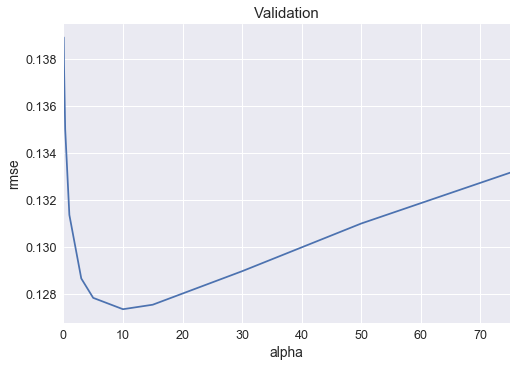

In [195]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [196]:
cv_ridge.min()

0.12733734668670751

### Lasso Model

In [197]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)
rmse_cv(model_lasso).mean()

0.12314421090977438

In [198]:
#Lasso model이 선택한 feature의 수알아보기
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 110 variables and eliminated the other 178 variables


In [199]:
lasso_preds = np.expm1(model_lasso.predict(X_test))
solution = pd.DataFrame({"id":test.Id, "SalePrice":lasso_preds})
solution.to_csv("./submit/2_LassoOrRidge(summary).csv", index = False)

![](./image/score.PNG)

- 라쏘 또는 릿지 회귀분석 결과 선형 회귀분석보다 좋은 결과값을 가져옴 : 0.12096
- 라쏘, 릿지는 적절한 변수를 alpha값으로 선정해주는데 있어서 좋은 결과.

[추후방안]
- 선형회귀에서부터 시작하여 적절한 설명변수의 조합을 분석하여 결과 스코어를 줄이는데 목표.
- 숫자형 변수의 표준화필요 및 숫자형 변수에서의 범주형 변수 추출.
- 필요없는 범주형 변수 추출(결측값이나 이상값이 있는경우 제거)
- 추후 결과값에 영향을 주는 설명변수의 선택이라는 데이터 전처리 과정이 중요할 듯.